# Import and Load

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_style('darkgrid')

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

In [124]:
df_train = pd.read_csv('./data/train.csv')
df_test = pd.read_csv('./data/test.csv')
df_spray = pd.read_csv('./data/spray.csv')
df_weather = pd.read_csv('./data/OhareDaily.csv')
df_traps = pd.read_csv('./data/trap_history.csv')

In [3]:
print(df_train.shape)
print(df_test.shape)
print(df_spray.shape)
print(df_weather.shape)
print(df_traps.shape)

(10506, 12)
(116293, 11)
(14835, 4)
(2163, 38)
(148, 8)


# Combine Trap info by date to sum NumMosquitos

In [125]:
df_train_short = pd.DataFrame(df_train.groupby(['Date', 'Address', 'Species', 'Block', 'Street', 'Trap',
       'AddressNumberAndStreet', 'Latitude', 'Longitude', 'AddressAccuracy'], as_index=False)['NumMosquitos', 'WnvPresent'].sum())

In [126]:
df_train_short['WnvPresent'].value_counts()

0     8018
1      409
2       31
3        9
4        2
7        1
6        1
5        1
10       1
9        1
8        1
Name: WnvPresent, dtype: int64

In [127]:
df_train_short['pct'] = df_train_short['WnvPresent'] / df_train_short['NumMosquitos']

In [128]:
df_train_short['WnvPresent'] = np.where(df_train_short['WnvPresent'] > 0, 1, 0)

In [37]:
df_train_short.head()

,Date,Address,Species,Block,Street,Trap,AddressNumberAndStreet,Latitude,Longitude,AddressAccuracy,NumMosquitos,WnvPresent,pct
0,2007-05-29,"1100 Roosevelt Road, Chicago, IL 60608, USA",CULEX PIPIENS/RESTUANS,11,W ROOSEVELT,T048,"1100 W ROOSEVELT, Chicago, IL",41.867108,-87.654224,8,1,0,0.0
1,2007-05-29,"1100 Roosevelt Road, Chicago, IL 60608, USA",CULEX RESTUANS,11,W ROOSEVELT,T048,"1100 W ROOSEVELT, Chicago, IL",41.867108,-87.654224,8,2,0,0.0
2,2007-05-29,"1100 South Peoria Street, Chicago, IL 60608, USA",CULEX RESTUANS,11,S PEORIA ST,T091,"1100 S PEORIA ST, Chicago, IL",41.862292,-87.648860,8,1,0,0.0
3,2007-05-29,"1100 West Chicago Avenue, Chicago, IL 60642, USA",CULEX RESTUANS,11,W CHICAGO,T049,"1100 W CHICAGO, Chicago, IL",41.896282,-87.655232,8,1,0,0.0
4,2007-05-29,"1500 North Long Avenue, Chicago, IL 60651, USA",CULEX RESTUANS,15,N LONG AVE,T153,"1500 N LONG AVE, Chicago, IL",41.907645,-87.760886,8,1,0,0.0


In [129]:
df_train_short['is_carrier'] = np.where(df_train_short['Species'] == 'CULEX PIPIENS/RESTUANS', 1,
                         np.where(df_train_short['Species'] == 'CULEX RESTUANS ', 1,
                         np.where(df_train_short['Species'] == 'CULEX PIPIENS ', 1,
                         np.where(df_train_short['Species'] == 'CULEX TARSALIS', 1, 0))))

                         

# Change Date column to Date time and Set as index

In [130]:
df_train_short['Date'] = pd.to_datetime(df_train_short['Date'])
df_weather['Date'] = pd.to_datetime(df_weather['Date'])

In [131]:
df_weather.set_index('Date', inplace=True)

In [132]:
df_train_short.set_index('Date', inplace=True)

# Merge Weather data onto Train Data

In [133]:
df_train_weather = pd.merge(left=df_train_short, right=df_weather, left_index=True, right_index=True)

### Reset Index on combined DataFrame

In [134]:
df_train_weather.reset_index(inplace=True)

### Set index to Trap to comine trap data

In [135]:
df_train_weather.set_index('Trap', inplace=True)
df_traps.set_index('Trap', inplace=True)

# Merge Trap Data onto Train and Weather Data

In [136]:
df_train_weather_traps = pd.merge(left=df_train_weather, right=df_traps, left_index=True, right_index=True)

In [137]:
df_train_weather_traps.reset_index(inplace=True)

# Model

In [159]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, roc_auc_score, auc
from sklearn import metrics 
from sklearn.metrics import classification_report

In [138]:
# set combined dataframe of train and weather to df 
df = df_train_weather_traps

In [139]:
# get dummies for each species
df = pd.get_dummies(df, columns=['Species'])

In [140]:
df.columns

Index(['Trap', 'Date', 'Address', 'Block', 'Street', 'AddressNumberAndStreet',
       'Latitude', 'Longitude', 'AddressAccuracy', 'NumMosquitos',
       'WnvPresent', 'pct', 'is_carrier', 'Average of Temp (F)',
       'Max of Temp (F)', 'Min of Temp (F)', 'Average of RH (%)',
       'Average of Dewpt (F)', 'Average of Wind Spd (mph)',
       'Sum of Precip (in)', 'Location', 'Lat', 'Lon', 'Elev', 'Month', 'Day',
       'Year', 'MaxT7', 'MaxT14', 'MaxT21', 'MinT7', 'MinT14', 'MinT21',
       'AvgT7', 'AvgT14', 'AvgT21', 'AvgT28', 'Rain7', 'Rain10', 'Rain14',
       'Rain17', 'Rain21', 'Rain24', 'Rain28', 'MaxR7', 'MaxR14', 'MaxR21',
       'MaxR2d7', 'MaxR2d14', 'MaxR2d21', 'any_positive', 'avg_mosq_per_obs',
       'n_obs', 'percent_pos', 'neighbor_mosq_score', 'neighbor_onehot_score',
       'neighbor_posrate_score', 'Species_CULEX ERRATICUS',
       'Species_CULEX PIPIENS', 'Species_CULEX PIPIENS/RESTUANS',
       'Species_CULEX RESTUANS', 'Species_CULEX SALINARIUS',
       'Species_

In [223]:
# create a list of maual feaures to be used for both train and test sets
features = ['is_carrier', 'Latitude', 'Longitude',
            'Month', 'Year', 'MaxT21', 'AvgT21',
            'Rain24', 'MaxR14', 
            'Species_CULEX ERRATICUS',
            'Species_CULEX PIPIENS', 'Species_CULEX PIPIENS/RESTUANS',
            'Species_CULEX RESTUANS', 'Species_CULEX SALINARIUS',
             'Species_CULEX TARSALIS', 'Species_CULEX TERRITANS'
    ]




In [224]:
# set X to the manually selected features above
X = df[features]

# set y equal to the target column
y = df['WnvPresent']

#train test split, stratify on y, set random state
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, stratify=y, random_state = 34)

# show shape of splits
print("X_train : " + str(X_train.shape))
print("X_test : " + str(X_test.shape))
print("y_train : " + str(y_train.shape))
print("y_test : " + str(y_test.shape))

X_train : (5932, 16)
X_test : (2543, 16)
y_train : (5932,)
y_test : (2543,)


In [203]:
ss = StandardScaler()
X_train = ss.fit_transform(X_train)
X_test = ss.transform(X_test)

# Logistic Regression

In [50]:
logreg = LogisticRegression()
params = {
    'penalty': ['l1', 'l2'],
    'C': np.linspace(1, 10, 5)
    
}
gs_logreg = GridSearchCV(logreg, param_grid=params , scoring='roc_auc', verbose=1, return_train_score=True)

gs_logreg.fit(X_train, y_train)

print(gs_logreg.best_params_)
print(gs_logreg.best_score_)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:   48.6s finished


{'C': 1.0, 'penalty': 'l2'}
0.8388488278844835


In [51]:
model = LogisticRegression(penalty='l2', C=1.0)
model.fit(X_train,y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

# PCA

In [49]:
from sklearn.decomposition import PCA

In [55]:
pca = PCA(n_components=20)
pca.fit(X_train)
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)
gs_logreg.fit(X_train_pca, y_train)

print(gs_logreg.best_params_)
print(gs_logreg.best_score_)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:   33.3s finished


{'C': 10.0, 'penalty': 'l1'}
0.8276845759700706


# Random Forest Classifier

In [ ]:
model = RandomForestClassifier(min_samples_split=3, min_samples_leaf=10, class_weight='balanced', n_estimators=1000)
model.fit(X_train,y_train)

In [179]:
params = {
    'min_samples_split': [3,4],
    'min_samples_leaf': range(9, 11, 1),
    'class_weight': ['balanced'],
    'n_estimators': [900, 1000],
}

gs_rf = GridSearchCV(RandomForestClassifier(), param_grid=params, scoring='roc_auc', verbose=1, cv=3, n_jobs=3)
gs_rf.fit(X_train, y_train)

print(gs_rf.best_params_)
print(gs_rf.best_score_)

Fitting 3 folds for each of 8 candidates, totalling 24 fits


[Parallel(n_jobs=3)]: Done  24 out of  24 | elapsed:   42.4s finished


{'class_weight': 'balanced', 'min_samples_leaf': 10, 'min_samples_split': 3, 'n_estimators': 900}
0.8204269666379987


In [204]:
model = RandomForestClassifier(min_samples_split=3, min_samples_leaf=10, class_weight='balanced', n_estimators=1000)
model.fit(X_train,y_train)

RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=10,
            min_samples_split=3, min_weight_fraction_leaf=0.0,
            n_estimators=1000, n_jobs=1, oob_score=False,
            random_state=None, verbose=0, warm_start=False)

# Evaluate Model

## Random Forrest v 1.0
RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=10,
            min_samples_split=3, min_weight_fraction_leaf=0.0,
            n_estimators=1000, n_jobs=1, oob_score=False,
            random_state=None, verbose=0, warm_start=False)
            
features = ['is_carrier', 'Latitude', 'Longitude',
            'Month', 'Year', 'MaxT21', 'AvgT21',
            'Rain24', 'MaxR14', 
            'Species_CULEX ERRATICUS',
            'Species_CULEX PIPIENS', 'Species_CULEX PIPIENS/RESTUANS',
            'Species_CULEX RESTUANS', 'Species_CULEX SALINARIUS',
             'Species_CULEX TARSALIS', 'Species_CULEX TERRITANS'
    ]

In [205]:
predictions = model.predict(X_test) 

In [208]:
cm = confusion_matrix(y_test, predictions, labels=[1,0])
cm_df = pd.DataFrame(cm, columns=['predicted pos wnv', 'predicted neg wnv'],
                     index=['actual pos wnv', 'actual neg wnv'])
cm_df

,predicted pos wnv,predicted neg wnv
actual pos wnv,84,53
actual neg wnv,301,2105


In [209]:
probs = model.predict_proba(X_test)
preds = probs[:,1]
fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
roc_auc = metrics.auc(fpr, tpr)

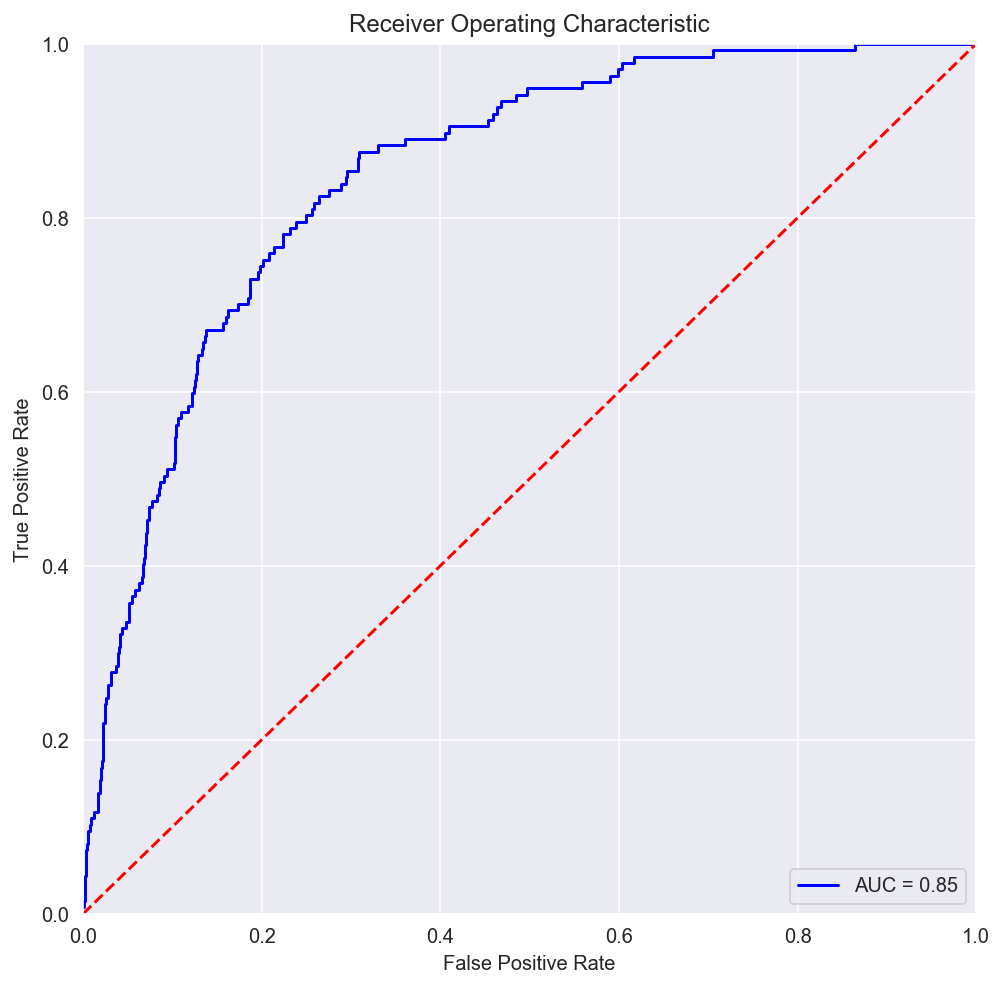

In [211]:
plt.figure(figsize=(8,8))
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

## Random Forrest v 1.1 - higher sensitivity, lower accuracy
RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=10,
            min_samples_split=3, min_weight_fraction_leaf=0.0,
            n_estimators=1000, n_jobs=1, oob_score=False,
            random_state=None, verbose=0, warm_start=False)
            
features = ['is_carrier',
            'Month', 'Year', 'MaxT21', 'AvgT21',
            'Rain24', 'MaxR14', 
            'Species_CULEX ERRATICUS',
            'Species_CULEX PIPIENS', 'Species_CULEX PIPIENS/RESTUANS',
            'Species_CULEX RESTUANS', 'Species_CULEX SALINARIUS',
             'Species_CULEX TARSALIS', 'Species_CULEX TERRITANS'
    ]

In [183]:
cm

array([[ 107,   30],
       [ 607, 1799]], dtype=int64)

In [185]:
cm_df = pd.DataFrame(cm, columns=['predicted pos wnv', 'predicted neg wnv'],
                     index=['actual pos wnv', 'actual neg wnv'])

In [186]:
cm_df

,predicted pos wnv,predicted neg wnv
actual pos wnv,107,30
actual neg wnv,607,1799


In [187]:
print(classification_report(y_test, predictions))

             precision    recall  f1-score   support

          0       0.98      0.75      0.85      2406
          1       0.15      0.78      0.25       137

avg / total       0.94      0.75      0.82      2543



In [188]:
probs = model.predict_proba(X_test)
preds = probs[:,1]
fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
roc_auc = metrics.auc(fpr, tpr)

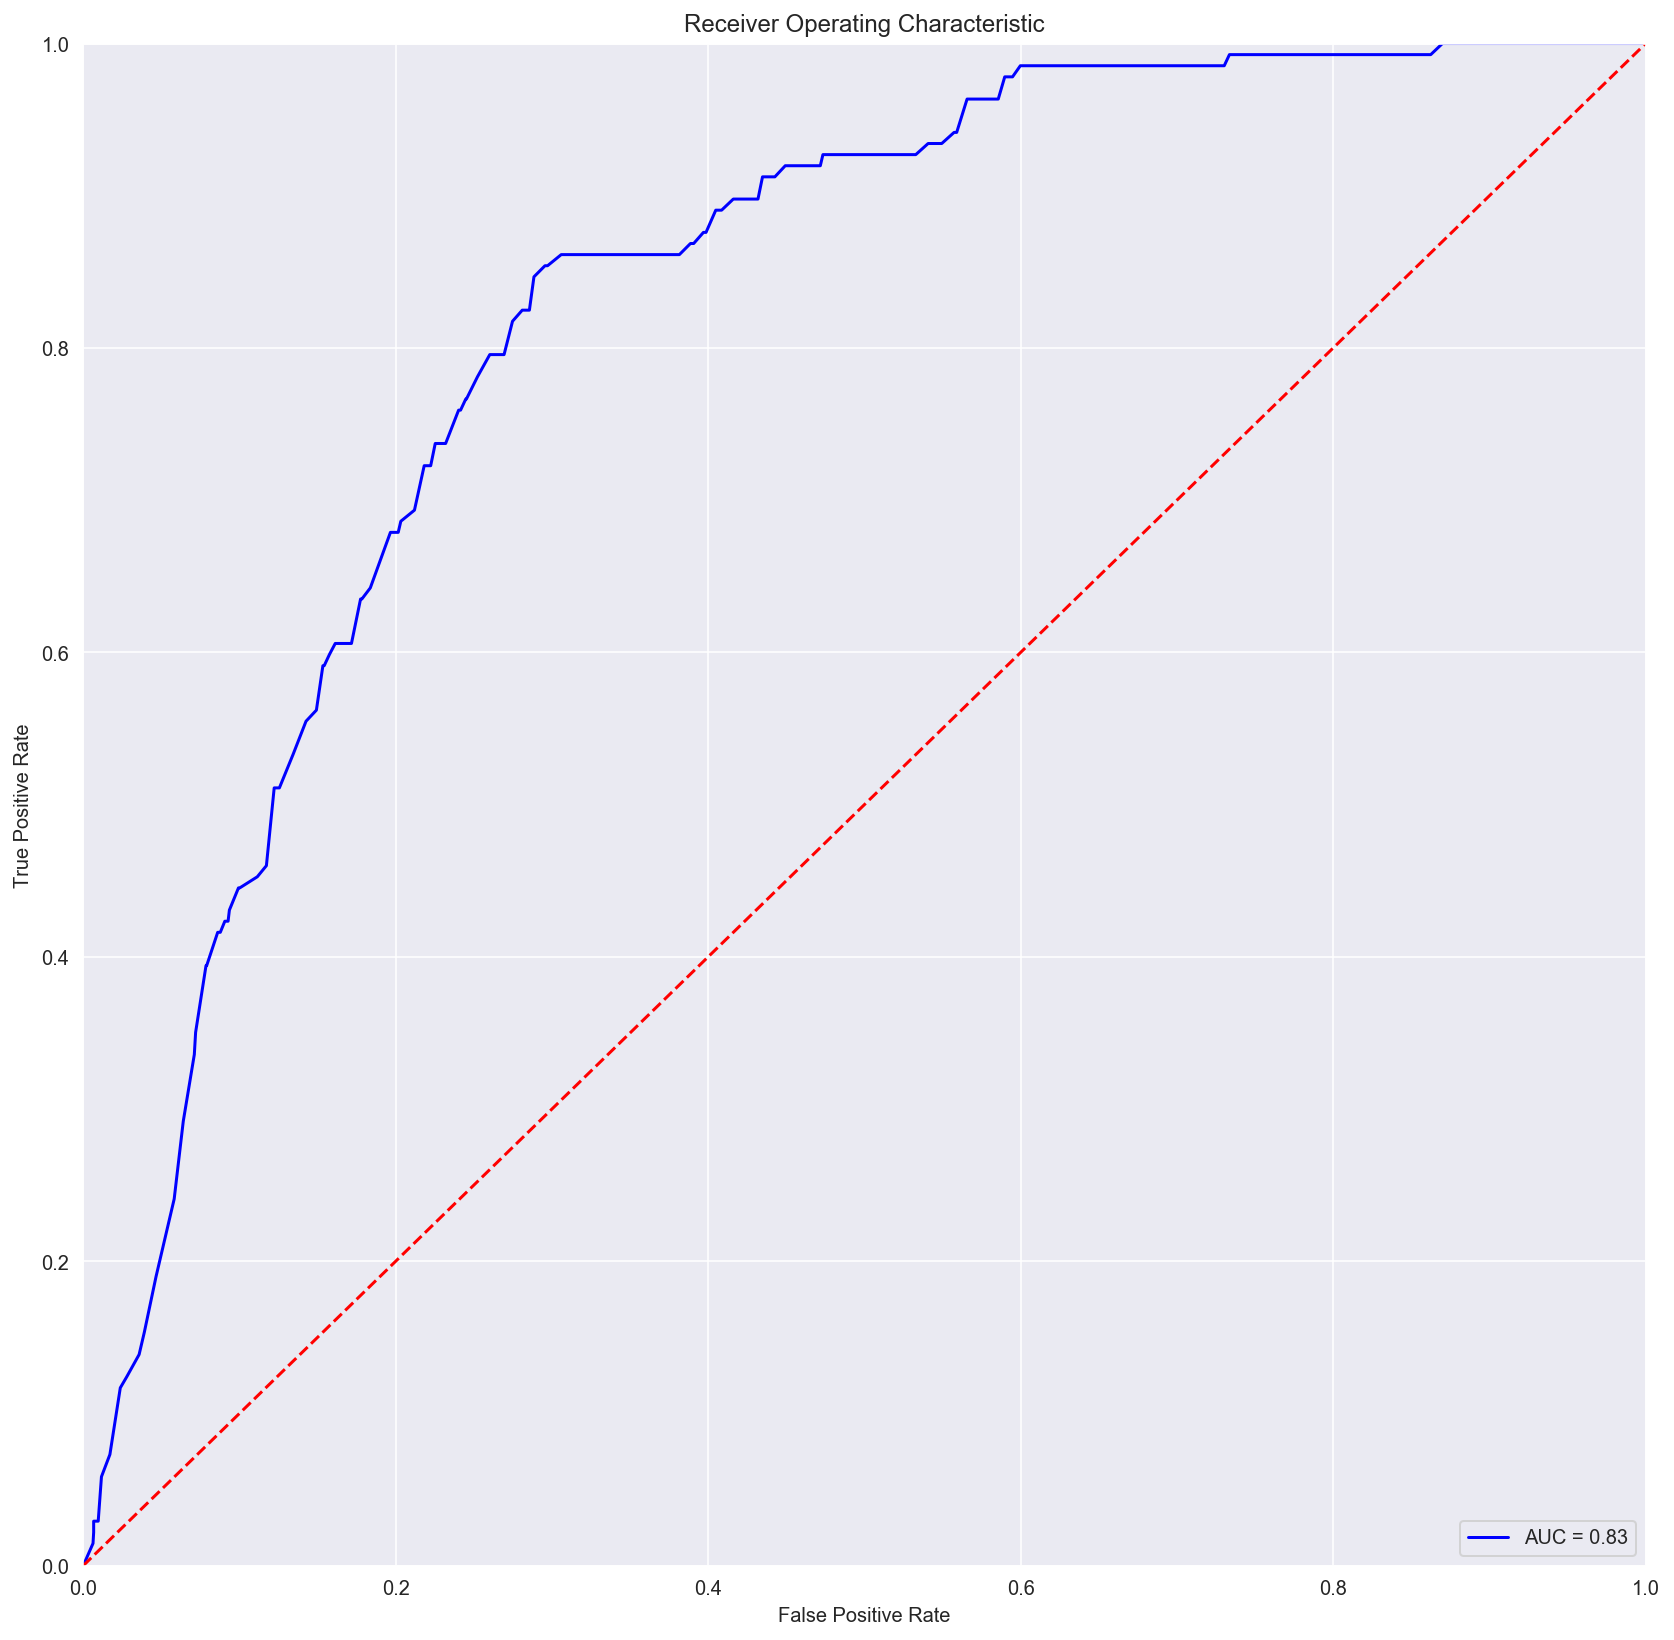

In [189]:
plt.figure(figsize=(14,14))
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

# Test Set

In [90]:
df_test = pd.read_csv('./data/test.csv')

In [91]:
df_test.shape

(116293, 11)

In [92]:
df_test['Date'] = pd.to_datetime(df_test['Date'])

In [93]:
df_test.set_index('Date', inplace=True)

## Merge Weather Data onto Test Data

In [94]:
df_test_weather = pd.merge(left=df_test, right=df_weather, left_index=True, right_index=True)

### Reset Index on combined DataFrame

In [95]:
df_test_weather.reset_index(inplace=True)

### Set index to Trap to comine trap data

In [96]:
df_test_weather.set_index('Trap', inplace=True)

## Merge Trap Data onto Test and Weather Data

In [97]:
df_test_weather_traps = pd.merge(left=df_test_weather, right=df_traps, left_index=True, right_index=True)

### Reset Index 

In [98]:
df_test_weather_traps.reset_index(inplace=True)

## Create Dummies for Species on Test Data 

In [99]:
df_test_weather_traps = pd.get_dummies(df_test_weather_traps, columns=['Species'])

## Set Features on Test Data

In [100]:
XX_test = df_test_weather_traps[features]
XX_test.shape

(115533, 46)

## Predict WNV

In [101]:
df_test_weather_traps['WnvPresent'] = model.predict(XX_test) 

## Create Upload File

In [102]:
upload = df_test_weather_traps.filter(['Id', 'WnvPresent'], axis=1)
upload = upload.set_index('Id')

In [103]:
upload.to_csv('wnvupload.csv')